# H&M Personalized Fashion Recommendation

## Project Overview
This project builds a **Personalized Fashion Recommendation System** using the **H&M Personalized Fashion Recommendations dataset**.  
The goal is to perform customer segmentation using Recency Frequency Monetary (RFM) Model and K-Means clustering to predict and recommend **relevant products** to customers based on their past interactions.

## Dataset Information
The dataset is sourced from [Kaggle's H&M Personalized Fashion Recommendations](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/).  
It consists of three main tables:

### 1️⃣ **Transactions (`transactions_train.csv`)**
- Contains historical purchase data of customers.
- **Columns:**
  - `t_dat` → Transaction date
  - `customer_id` → Unique customer identifier
  - `article_id` → Product ID
  - `price` → Price of the product at purchase
  - `sales_channel_id` → 1 = Online, 2 = Store purchase

### 2️⃣ **Articles (`articles.csv`)**
- Contains metadata about the fashion items.
- **Columns:**
  - `article_id` → Unique product ID
  - `product_code` → Product category code
  - `product_type_no` → Product type number
  - `graphical_appearance_no` → Image style
  - `perceived_colour_value_id` → Light/Dark color category
  - `perceived_colour_master_id` → Main color (e.g., red, blue)
  - `department_no` → Department category
  - `detail_desc` → Detailed product description

### 3️⃣ **Customers (`customers.csv`)**
- Contains information about each customer.
- **Columns:**
  - `customer_id` → Unique customer identifier
  - `FN` → Loyalty program membership flag
  - `Active` → Active status in loyalty program
  - `club_member_status` → Membership type
  - `fashion_news_frequency` → Email subscription frequency
  - `age` → Customer's age

## **Project Workflow**
1. **Exploratory Data Analysis (EDA)**:
   - Purchase trends over time
   - Bestselling products
   - RFM and K-Means Clustering for customer segmentation
2. **Building Recommendation Models**:
   - Use co-occurence to find most frequently purchase together products
3. **Deploying the Model**:
   - Recommend Iems Frequently Purchased Together
   - Generating top 12 fashion recommendations per customer
   - Fill the rest with popular items

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import cudf, gc
import cv2, matplotlib.pyplot as plt
from os.path import exists
print('RAPIDS version',cudf.__version__)

RAPIDS version 21.10.01


# Let's load and preview data

In [5]:
articles = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/articles.csv")
customers = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/customers.csv")
transactions = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv")

In [6]:
articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   article_id                    105542 non-null  int64 
 1   product_code                  105542 non-null  int64 
 2   prod_name                     105542 non-null  object
 3   product_type_no               105542 non-null  int64 
 4   product_type_name             105542 non-null  object
 5   product_group_name            105542 non-null  object
 6   graphical_appearance_no       105542 non-null  int64 
 7   graphical_appearance_name     105542 non-null  object
 8   colour_group_code             105542 non-null  int64 
 9   colour_group_name             105542 non-null  object
 10  perceived_colour_value_id     105542 non-null  int64 
 11  perceived_colour_value_name   105542 non-null  object
 12  perceived_colour_master_id    105542 non-null  int64 
 13 

In [7]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371980 entries, 0 to 1371979
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   customer_id             1371980 non-null  object 
 1   FN                      476930 non-null   float64
 2   Active                  464404 non-null   float64
 3   club_member_status      1365918 non-null  object 
 4   fashion_news_frequency  1355971 non-null  object 
 5   age                     1356119 non-null  float64
 6   postal_code             1371980 non-null  object 
dtypes: float64(3), object(4)
memory usage: 73.3+ MB


In [8]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31788324 entries, 0 to 31788323
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   t_dat             object 
 1   customer_id       object 
 2   article_id        int64  
 3   price             float64
 4   sales_channel_id  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.2+ GB


We use CUDF to reduce memory usage

In [9]:
# LOAD TRANSACTIONS DATAFRAME
df = cudf.read_csv('../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv')
print('Transactions shape',df.shape)
display( df.head() )

# REDUCE MEMORY OF DATAFRAME
df = df[['customer_id','article_id']]
df.customer_id = df.customer_id.str[-16:].str.hex_to_int().astype('int64')
df.article_id = df.article_id.astype('int32')
_ = gc.collect()

Transactions shape (31788324, 5)


t_dat                                        customer_id  article_id  \
0  2018-09-20  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   663713001   
1  2018-09-20  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   541518023   
2  2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   505221004   
3  2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   685687003   
4  2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   685687004   

      price  sales_channel_id  
0  0.050831                 2  
1  0.030492                 2  
2  0.015237                 2  
3  0.016932                 2  
4  0.016932                 2

# Exploratory Data Analysis

## 1. Customers Data EDA

There are no missing values or duplicates in customer dataset

In [10]:
# Check for missing values
print("\nMissing Values in Customers Dataframe:")
print(customers.isnull().sum())


Missing Values in Customers Dataframe:
customer_id                    0
FN                        895050
Active                    907576
club_member_status          6062
fashion_news_frequency     16009
age                        15861
postal_code                    0
dtype: int64


In [11]:
customers.shape[0] - customers['customer_id'].nunique()

0

The most common age is 21 - 23

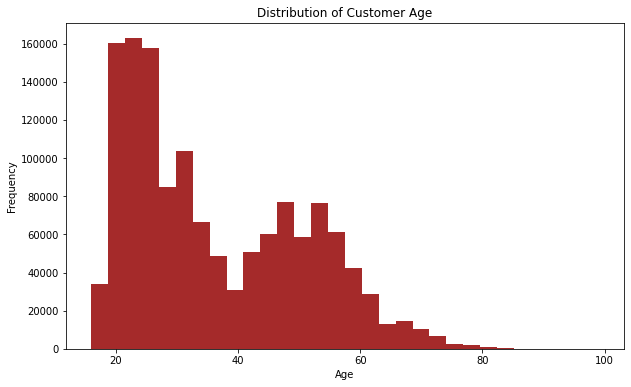

In [12]:
# Exploratory data analysis for customers
# Histogram of age
plt.figure(figsize=(10, 6))
plt.hist(customers['age'].dropna(), bins=30, color ='brown')  # Drop NA values for histogram
plt.title('Distribution of Customer Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

## 2. Articles Data EDA

Ladieswear accounts for the highest portion of Product Index while Sportwear accounts for the lowest

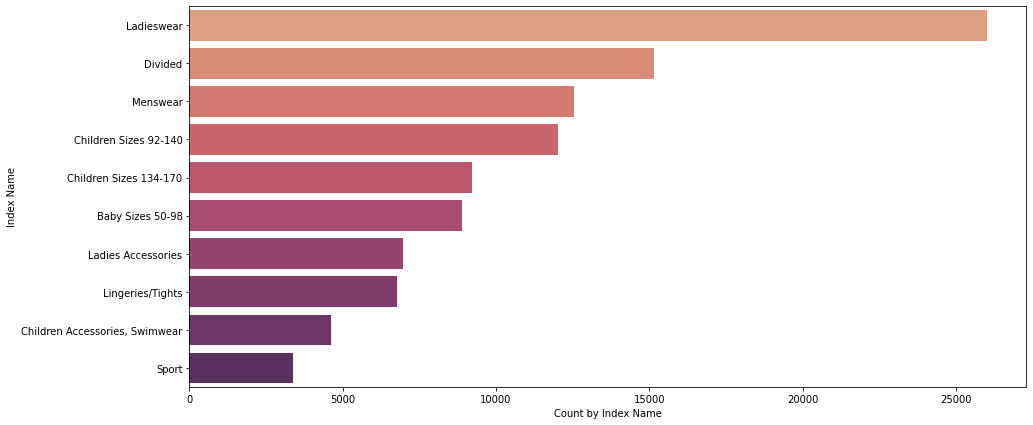

In [13]:
# Precompute counts and sort in descending order
sorted_articles = articles['index_name'].value_counts().reset_index()
sorted_articles.columns = ['index_name', 'count']
sorted_articles = sorted_articles.sort_values(by='count', ascending=False)

# Plot
f, ax = plt.subplots(figsize=(15, 7))
ax = sns.barplot(data=sorted_articles, y='index_name', x='count', palette="flare")
ax.set_xlabel('Count by Index Name')
ax.set_ylabel('Index Name')

plt.show()

There are about 45.8K unique products in this dataset

In [14]:
for col in articles.columns:
    if not 'no' in col and not 'code' in col and not 'id' in col:
        un_n = articles[col].nunique()
        print(f'no of unique {col}: {un_n}')

no of unique prod_name: 45875
no of unique product_type_name: 131
no of unique product_group_name: 19
no of unique graphical_appearance_name: 30
no of unique colour_group_name: 50
no of unique perceived_colour_value_name: 8
no of unique perceived_colour_master_name: 20
no of unique department_name: 250
no of unique index_name: 10
no of unique index_group_name: 5
no of unique section_name: 56
no of unique garment_group_name: 21
no of unique detail_desc: 43404


## 3. Transactions Data EDA

There are no missing values in Transactions data

In [15]:
print("\nMissing Values in Transactions Dataframe:")
print(transactions.isnull().sum())


Missing Values in Transactions Dataframe:
t_dat               0
customer_id         0
article_id          0
price               0
sales_channel_id    0
dtype: int64


Transactions data ranged from 2018-09-20 to 2020-09-22

In [16]:
# Convert 't_dat' to datetime objects
transactions['t_dat'] = pd.to_datetime(transactions['t_dat'])

# Analyze transaction dates
print("\nTransaction Date Range:")
print(f"Minimum Date: {transactions['t_dat'].min()}")
print(f"Maximum Date: {transactions['t_dat'].max()}")


Transaction Date Range:
Minimum Date: 2018-09-20 00:00:00
Maximum Date: 2020-09-22 00:00:00


Number of transactions peaked during October, December, and April, possibly from End-of-Season Sale

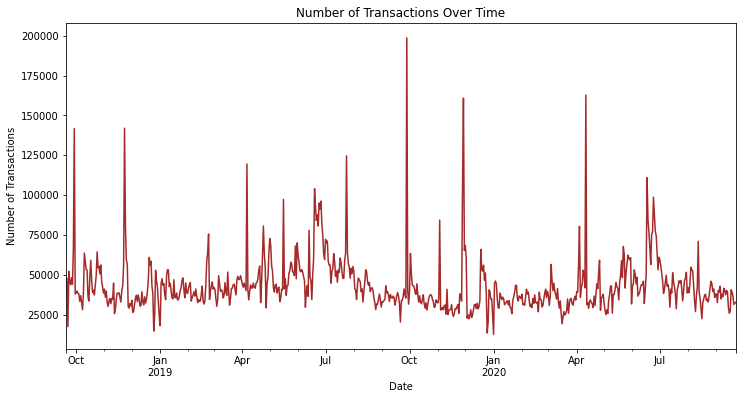

In [17]:
# Visualize transaction counts over time
plt.figure(figsize=(12, 6))
transactions['t_dat'].value_counts().sort_index().plot(color = 'brown')
plt.title('Number of Transactions Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.show()

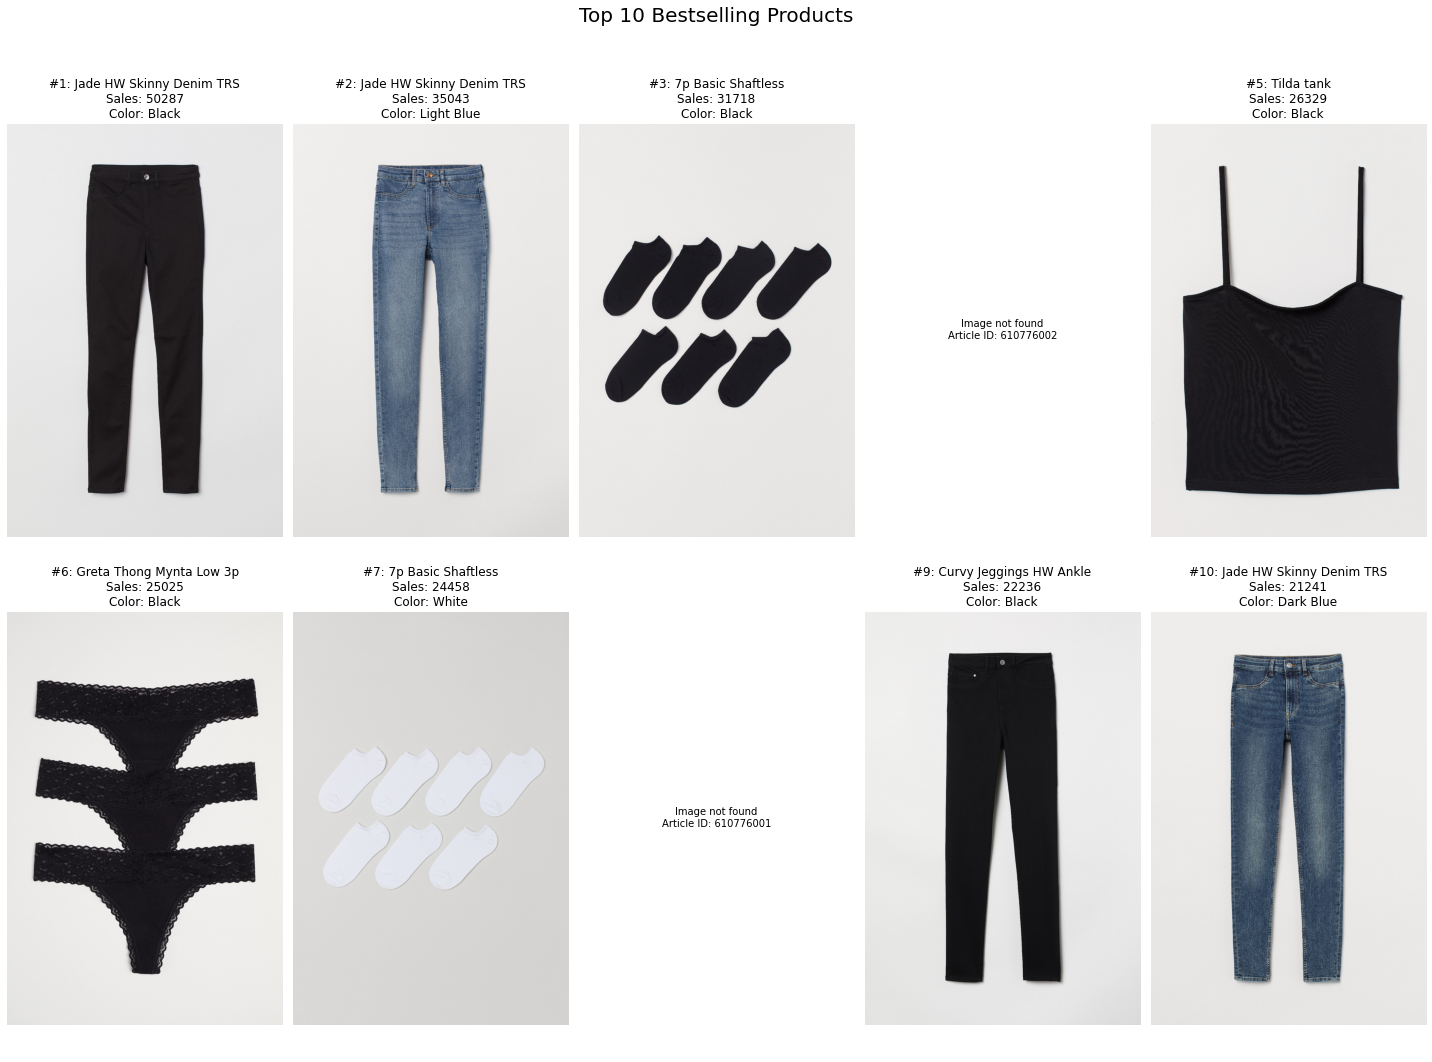

Top 10 Bestselling Products Details:
 article_id                prod_name product_type_name colour_group_name   department_name garment_group_name  sales_count
  706016001 Jade HW Skinny Denim TRS          Trousers             Black          Trousers           Trousers        50287
  706016002 Jade HW Skinny Denim TRS          Trousers        Light Blue          Trousers           Trousers        35043
  372860001       7p Basic Shaftless             Socks             Black  Shopbasket Socks   Socks and Tights        31718
  610776002                Tilly (1)           T-shirt             Black      Jersey Basic       Jersey Basic        30199
  759871002               Tilda tank          Vest top             Black EQ Divided Basics       Jersey Basic        26329
  464297007 Greta Thong Mynta Low 3p  Underwear bottom             Black   Casual Lingerie  Under-, Nightwear        25025
  372860002       7p Basic Shaftless             Socks             White  Shopbasket Socks   Socks and

In [30]:
# Find top 10 bestselling products
bestsellers = transactions['article_id'].value_counts().head(10)
top_10_ids = bestsellers.index.tolist()

# Get details of top 10 products
top_products = articles[articles['article_id'].isin(top_10_ids)]

# Merge with sales count
top_products = top_products.merge(
    pd.DataFrame({'article_id': bestsellers.index, 'sales_count': bestsellers.values}),
    on='article_id'
)

# Sort by sales count
top_products = top_products.sort_values('sales_count', ascending=False)

# Path to images
BASE = '../input/h-and-m-personalized-fashion-recommendations/images/'

# Create a figure to display the top 10 products
plt.figure(figsize=(20, 15))

# Loop through top 10 products
for i, (_, product) in enumerate(top_products.iterrows()):
    article_id = product['article_id']
    
    # Format image path
    img_path = f"{BASE}0{str(article_id)[:2]}/0{str(article_id)}.jpg"
    
    if exists(img_path):
        # Read and convert image from BGR to RGB
        img = cv2.imread(img_path)[:,:,::-1]
        
        # Create subplot
        plt.subplot(2, 5, i+1)
        
        # Display product information
        title = f"#{i+1}: {product['prod_name']}\n"
        title += f"Sales: {product['sales_count']}\n"
        title += f"Color: {product['colour_group_name']}"
        
        plt.title(title, fontsize=12)
        plt.imshow(img)
        plt.axis('off')
    else:
        plt.subplot(2, 5, i+1)
        plt.text(0.5, 0.5, f"Image not found\nArticle ID: {article_id}", 
                 horizontalalignment='center', verticalalignment='center')
        plt.axis('off')

plt.suptitle('Top 10 Bestselling Products', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig('top_10_bestsellers.png', dpi=300)
plt.show()

# Display detailed information table
print("Top 10 Bestselling Products Details:")
display_cols = ['article_id', 'prod_name', 'product_type_name', 'colour_group_name', 
                'department_name', 'garment_group_name', 'sales_count']
print(top_products[display_cols].to_string(index=False))


# Customers Segmentation using RFM Model

Load transactions data with cudf for memory optimization 

In [18]:
train = cudf.read_csv('../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv')
train['customer_id'] = train['customer_id'].str[-16:].str.hex_to_int().astype('int64')
train['article_id'] = train.article_id.astype('int32')
train.t_dat = cudf.to_datetime(train.t_dat)
train = train[['t_dat','customer_id','article_id']]
train.to_parquet('train.pqt',index=False)
print( train.shape )
train.head()

(31788324, 3)


t_dat          customer_id  article_id
0 2018-09-20    -6846340800584936   663713001
1 2018-09-20    -6846340800584936   541518023
2 2018-09-20 -8334631767138808638   505221004
3 2018-09-20 -8334631767138808638   685687003
4 2018-09-20 -8334631767138808638   685687004

# Create RFM data

In [19]:
import cudf
import cupy as cp

# Load the dataset (GPU-accelerated DataFrame)
train = cudf.read_csv('../input/h-and-m-personalized-fashion-recommendations/transactions_train.csv')

# Convert customer_id to integer format
train['customer_id'] = train['customer_id'].str[-16:].str.hex_to_int().astype('int64')
train['article_id'] = train['article_id'].astype('int32')

# Convert date to datetime
train['t_dat'] = cudf.to_datetime(train['t_dat'])

# Compute the max order date in the dataset for Recency calculation
max_date = train['t_dat'].max()

# Compute Recency (Days since last purchase)
recency_df = train.groupby('customer_id').agg({'t_dat': 'max'}).reset_index()
recency_df['recency'] = (max_date - recency_df['t_dat']).dt.days
recency_df = recency_df[['customer_id', 'recency']]

# Compute Frequency (Total number of purchases)
frequency_df = train.groupby('customer_id').agg({'article_id': 'count'}).reset_index()
frequency_df = frequency_df.rename(columns={'article_id': 'frequency'})

# Compute Monetary (Unique items bought)
monetary_df = train.groupby('customer_id').agg({'article_id': 'nunique'}).reset_index()
monetary_df = monetary_df.rename(columns={'article_id': 'monetary'})

# Merge all RFM metrics
rfm = recency_df.merge(frequency_df, on='customer_id').merge(monetary_df, on='customer_id')

# Sort by best RFM scores (lowest recency, highest frequency & monetary)
rfm_sorted = rfm.sort_values(by=['recency', 'frequency', 'monetary'], ascending=[True, False, False])

# Save as Parquet file (GPU-optimized format)
rfm_sorted.to_parquet('rfm_model.pqt', index=False)

# Display top customers
print(rfm_sorted.head(10))

                customer_id  recency  frequency  monetary
877461  7398229172292340849        0       1441      1068
449246 -4781325834093528838        0       1170       836
577303 -2110333707337082135        0       1066       859
173951 -8684636470525030339        0       1022       840
52676   2768447994533782618        0       1009       649
725660  2636587246054202986        0        965       700
71899  -2021215128221699234        0        921       616
206284  7952062577868193503        0        889       671
945434 -5879043914330186295        0        820       587
168029   944382517877193631        0        763       600


/opt/conda/lib/python3.7/site-packages/cudf/core/frame.py:2600: UserWarning: When using a sequence of booleans for `ascending`, `na_position` flag is not yet supported and defaults to treating nulls as greater than all numbers
  "When using a sequence of booleans for `ascending`, "


# Check the distribution of data

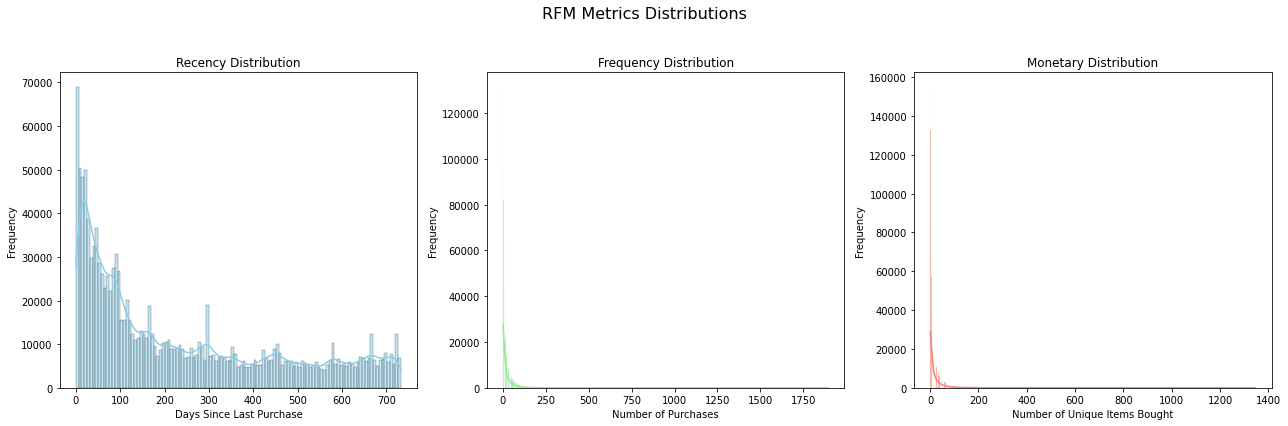

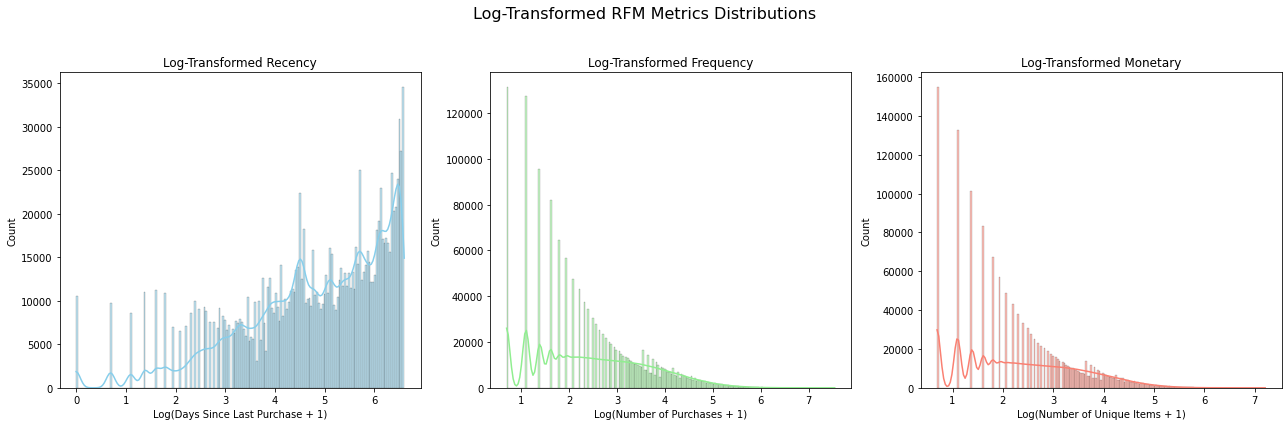

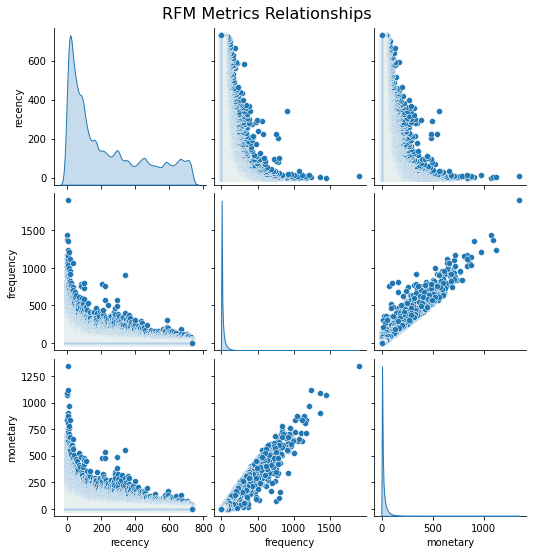

RFM Summary Statistics:
            recency     frequency      monetary
count  1.362281e+06  1.362281e+06  1.362281e+06
mean   2.351484e+02  2.333463e+01  2.004464e+01
std    2.211188e+02  3.924225e+01  3.198025e+01
min    0.000000e+00  1.000000e+00  1.000000e+00
25%    4.800000e+01  3.000000e+00  3.000000e+00
50%    1.510000e+02  9.000000e+00  8.000000e+00
75%    3.980000e+02  2.700000e+01  2.400000e+01
max    7.330000e+02  1.895000e+03  1.346000e+03


In [20]:
# Convert cuDF DataFrame to pandas for plotting
rfm_pandas = rfm_sorted.to_pandas()

# Set up the figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('RFM Metrics Distributions', fontsize=16)

# Plot Recency distribution
sns.histplot(rfm_pandas['recency'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Recency Distribution')
axes[0].set_xlabel('Days Since Last Purchase')
axes[0].set_ylabel('Frequency')

# Plot Frequency distribution
sns.histplot(rfm_pandas['frequency'], kde=True, ax=axes[1], color='lightgreen')
axes[1].set_title('Frequency Distribution')
axes[1].set_xlabel('Number of Purchases')
axes[1].set_ylabel('Frequency')

# Plot Monetary distribution
sns.histplot(rfm_pandas['monetary'], kde=True, ax=axes[2], color='salmon')
axes[2].set_title('Monetary Distribution')
axes[2].set_xlabel('Number of Unique Items Bought')
axes[2].set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('rfm_distributions.png', dpi=300)
plt.show()

# For better visualization of skewed distributions, also create log-transformed plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Log-Transformed RFM Metrics Distributions', fontsize=16)

# Add 1 before log transform to handle zeros
sns.histplot(np.log1p(rfm_pandas['recency']), kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Log-Transformed Recency')
axes[0].set_xlabel('Log(Days Since Last Purchase + 1)')

sns.histplot(np.log1p(rfm_pandas['frequency']), kde=True, ax=axes[1], color='lightgreen')
axes[1].set_title('Log-Transformed Frequency')
axes[1].set_xlabel('Log(Number of Purchases + 1)')

sns.histplot(np.log1p(rfm_pandas['monetary']), kde=True, ax=axes[2], color='salmon')
axes[2].set_title('Log-Transformed Monetary')
axes[2].set_xlabel('Log(Number of Unique Items + 1)')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('rfm_log_distributions.png', dpi=300)
plt.show()

# Create a pairplot to visualize relationships between RFM metrics
sns.pairplot(rfm_pandas[['recency', 'frequency', 'monetary']], diag_kind='kde')
plt.suptitle('RFM Metrics Relationships', y=1.02, fontsize=16)
plt.savefig('rfm_pairplot.png', dpi=300)
plt.show()

# Print summary statistics
print("RFM Summary Statistics:")
print(rfm_pandas[['recency', 'frequency', 'monetary']].describe())

In [21]:
from scipy.stats import skew

# For each column in rfm_sorted
for col in ['recency', 'frequency', 'monetary']:
    skewness = skew(rfm_sorted[col].values_host)
    print(f"Skewness of {col}: {skewness:.5f}")


Skewness of recency: 0.80158
Skewness of frequency: 5.24318
Skewness of monetary: 4.57697


Apply log transformation to combat severe positive skewness

In [22]:
# For frequency column
freq_data = rfm_pandas['frequency'].values
original_freq_skew = skew(freq_data)

# Log transformation for frequency
freq_log = np.log1p(freq_data)  # log(x+1) to handle zeros
log_freq_skew = skew(freq_log)

# For monetary column
mon_data = rfm_pandas['monetary'].values
original_mon_skew = skew(mon_data)

# Log transformation for monetary
mon_log = np.log1p(mon_data)  # log(x+1) to handle zeros
log_mon_skew = skew(mon_log)

# Print summary of skewness values before and after log transformation
print("Skewness before and after log transformation:")
print(f"Frequency - Original: {original_freq_skew:.5f}, Log-transformed: {log_freq_skew:.5f}")
print(f"Monetary - Original: {original_mon_skew:.5f}, Log-transformed: {log_mon_skew:.5f}")
print(f"Frequency - Skewness reduction: {original_freq_skew - log_freq_skew:.5f} ({(1 - log_freq_skew/original_freq_skew)*100:.2f}%)")
print(f"Monetary - Skewness reduction: {original_mon_skew - log_mon_skew:.5f} ({(1 - log_mon_skew/original_mon_skew)*100:.2f}%)")

# Add the log-transformed columns to the rfm_pandas dataframe
rfm_pandas['frequency_log'] = freq_log
rfm_pandas['monetary_log'] = mon_log

# Show the first few rows of the dataframe with the new columns
print("\nDataframe with log-transformed columns:")
print(rfm_pandas[['frequency', 'frequency_log', 'monetary', 'monetary_log']].head())


Skewness before and after log transformation:
Frequency - Original: 5.24318, Log-transformed: 0.37293
Monetary - Original: 4.57697, Log-transformed: 0.38241
Frequency - Skewness reduction: 4.87025 (92.89%)
Monetary - Skewness reduction: 4.19455 (91.64%)

Dataframe with log-transformed columns:
        frequency  frequency_log  monetary  monetary_log
877461       1441       7.273786      1068      6.974479
449246       1170       7.065613       836      6.729824
577303       1066       6.972606       859      6.756932
173951       1022       6.930495       840      6.734592
52676        1009       6.917706       649      6.476972


Since K-Means model is sensitive to feature scale, we will normalize data

In [23]:
from sklearn.preprocessing import StandardScaler

# Create a copy of the DataFrame to avoid modifying the original
rfm_scaled = rfm_pandas.copy()

# Features to scale
features = ['recency', 'frequency_log', 'monetary_log']

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the features
scaled_features = scaler.fit_transform(rfm_scaled[features])

# Create a DataFrame with the scaled features
scaled_df = pd.DataFrame(scaled_features, columns=[f'{col}_scaled' for col in features])

# Add the scaled features to the original DataFrame
rfm_scaled = pd.concat([rfm_scaled, scaled_df], axis=1)

# Display the first few rows of the DataFrame with original and scaled features
print(rfm_scaled[['customer_id', 'recency', 'recency_scaled', 
                 'frequency_log', 'frequency_log_scaled',
                 'monetary_log', 'monetary_log_scaled']].head())

# Verify that scaled features have mean ≈ 0 and std ≈ 1
print("\nMean of scaled features:")
print(rfm_scaled[[col for col in rfm_scaled.columns if col.endswith('_scaled')]].mean())

print("\nStandard deviation of scaled features:")
print(rfm_scaled[[col for col in rfm_scaled.columns if col.endswith('_scaled')]].std())


           customer_id  recency  recency_scaled  frequency_log  \
0 -5362683030790685599      485       -1.063449       3.401197   
1 -8288792411900277887      559       -1.063449       1.791759   
2 -2019553148850297090      120       -1.063449       1.386294   
3  5792153945835032916       83       -1.063449       2.772589   
4  3993407713199153060      182       -1.063449       1.791759   

   frequency_log_scaled  monetary_log  monetary_log_scaled  
0              4.061837      3.218876             4.011449  
1              3.886665      1.791759             3.799495  
2              3.808402      1.386294             3.822980  
3              3.772967      2.772589             3.803626  
4              3.762205      1.791759             3.580440  

Mean of scaled features:
recency_scaled          1.390299e-13
frequency_log_scaled   -1.721889e-12
monetary_log_scaled     2.566865e-12
dtype: float64

Standard deviation of scaled features:
recency_scaled          1.0
frequency_log_sca

# Clustering with K-Means 

## First we need to choose the optimal k neighbors 

From the Elbow Method, we will look for the "bend" in the inertia curve where adding more clusters doesn't significantly reduce the within-cluster sum of squares.

Elbow point detected at k = 5


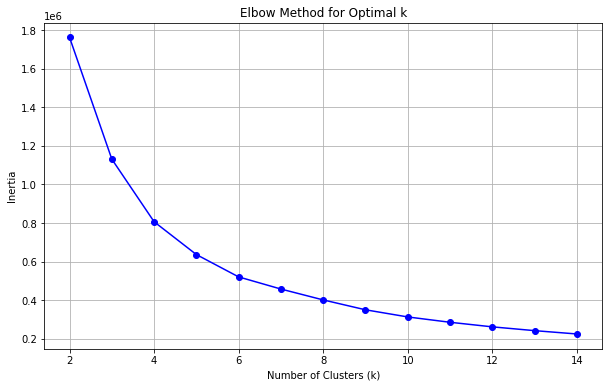

In [27]:
# Import GPU-accelerated libraries
import cudf
import cuml
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from kneed import KneeLocator

# Convert pandas DataFrame to cuDF
features_gpu = cudf.DataFrame(rfm_scaled[['recency_scaled', 'frequency_log_scaled', 'monetary_log_scaled']])

# Elbow Method with GPU acceleration
inertia = []
k_range = range(2, 15)

for k in k_range:
    kmeans = cuKMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features_gpu)
    inertia.append(kmeans.inertia_)

# Use kneed to find the elbow point
kl = KneeLocator(list(k_range), inertia, curve='convex', direction='decreasing')
elbow_k = kl.elbow
print(f"Elbow point detected at k = {elbow_k}")

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.savefig('elbow_method.png')
plt.show()

Apply K-Means with the K = 5


Cluster Summary:
            recency  frequency   monetary  recency_scaled  \
cluster                                                     
0        235.058647  23.302201  20.027629        1.578148   
1        234.659283  23.425108  20.114914       -0.328699   
2        234.911325  23.294529  20.017152       -0.792296   
3        235.152305  23.346814  20.028697        1.013059   
4        235.798398  23.302306  20.023935       -0.630620   

         frequency_log_scaled  monetary_log_scaled   count  
cluster                                                     
0                   -1.056107            -1.054047  234063  
1                   -0.909527            -0.910687  311669  
2                    1.484241             1.490619  273267  
3                   -0.006402            -0.023135  177755  
4                    0.345285             0.348324  365527  


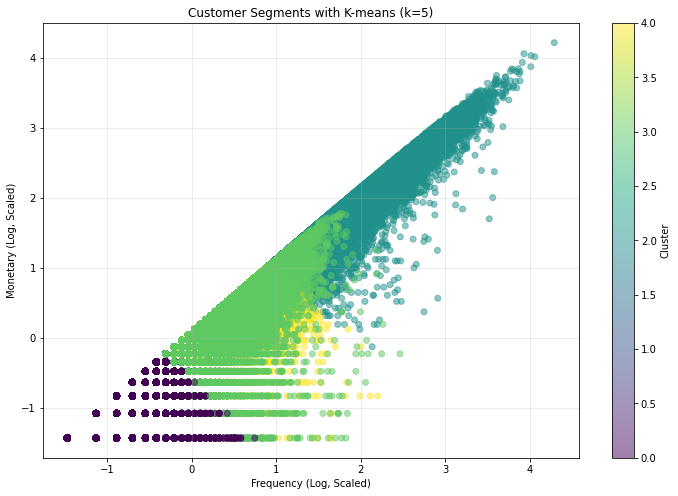

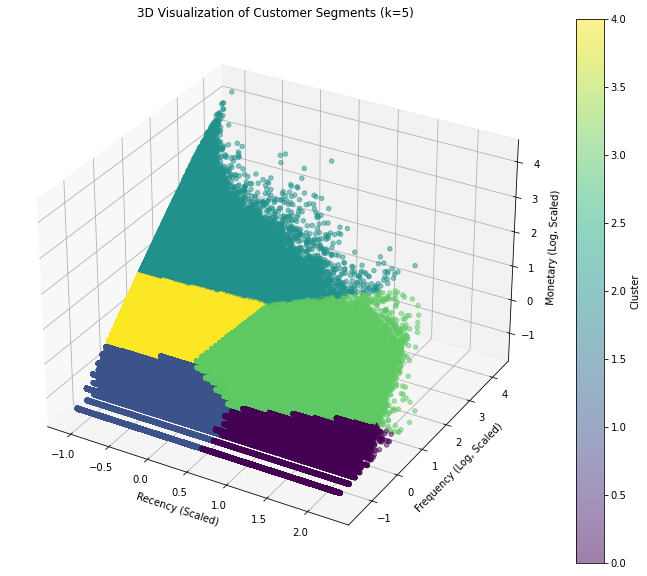

In [28]:
features_for_clustering = rfm_scaled[['recency_scaled', 'frequency_log_scaled', 'monetary_log_scaled']]
recommended_k = elbow_k

# Apply K-means with the recommended k
final_kmeans = KMeans(n_clusters=elbow_k, random_state=42, n_init=10)
rfm_scaled['cluster'] = final_kmeans.fit_predict(features_for_clustering)

# Analyze the resulting clusters
cluster_summary = rfm_scaled.groupby('cluster').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'mean',
    'recency_scaled': 'mean',
    'frequency_log_scaled': 'mean',
    'monetary_log_scaled': 'mean',
    'customer_id': 'count'
}).rename(columns={'customer_id': 'count'})

print("\nCluster Summary:")
print(cluster_summary)

# Visualize the clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(rfm_scaled['frequency_log_scaled'], 
                     rfm_scaled['monetary_log_scaled'],
                     c=rfm_scaled['cluster'], 
                     cmap='viridis', 
                     alpha=0.5)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('Frequency (Log, Scaled)')
plt.ylabel('Monetary (Log, Scaled)')
plt.title(f'Customer Segments with K-means (k={recommended_k})')
plt.grid(True, alpha=0.3)
plt.savefig('cluster_visualization.png')
plt.show()

# 3D visualization
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(rfm_scaled['recency_scaled'], 
                    rfm_scaled['frequency_log_scaled'],
                    rfm_scaled['monetary_log_scaled'],
                    c=rfm_scaled['cluster'],
                    cmap='viridis',
                    alpha=0.5)
ax.set_xlabel('Recency (Scaled)')
ax.set_ylabel('Frequency (Log, Scaled)')
ax.set_zlabel('Monetary (Log, Scaled)')
plt.colorbar(scatter, label='Cluster')
plt.title(f'3D Visualization of Customer Segments (k={recommended_k})')
plt.savefig('3d_cluster_visualization.png')
plt.show()

# Interpreting the K-means Clusters (k=5)

Based on the 3D visualization and cluster summary, I can provide an interpretation of your 5 customer segments:

## Cluster 0 (Teal/Blue-Green, Top)
- **Characteristics**: High recency (1.58 scaled), low frequency (-1.06), low monetary value (-1.05)
- **Interpretation**: These appear to be **recent but low-value customers** who have made purchases recently but don't buy frequently and spend less than average.
- **Size**: 234,063 customers

## Cluster 1 (Green, Middle-Right)
- **Characteristics**: Negative recency (-0.33), slightly below average frequency (-0.91), below average monetary (-0.91)
- **Interpretation**: These represent **inactive, low-value customers** who haven't purchased recently and have below-average purchase frequency and spending.
- **Size**: 311,669 customers

## Cluster 2 (Yellow, Bottom-Left)
- **Characteristics**: Very negative recency (-0.79), highest frequency (1.48), highest monetary (1.49)
- **Interpretation**: These are your **inactive high-value customers** - they haven't purchased recently but historically had high frequency and spending. These are valuable customers you might want to win back.
- **Size**: 273,267 customers

## Cluster 3 (Dark Blue, Bottom)
- **Characteristics**: Positive recency (1.01), average frequency (-0.01), average monetary (-0.02)
- **Interpretation**: These are **recent average-value customers** who have made purchases recently with average frequency and spending.
- **Size**: 177,755 customers

## Cluster 4 (Purple, Bottom-Right)
- **Characteristics**: Negative recency (-0.63), above average frequency (0.35), above average monetary (0.35)
- **Interpretation**: These represent **moderately inactive, above-average value customers** who haven't purchased very recently but have above-average purchase frequency and spending.
- **Size**: 365,527 customers (largest segment)

## Business Recommendations:
1. **Cluster 0**: Convert these recent customers into repeat buyers with loyalty incentives
2. **Cluster 1**: Consider targeted reactivation campaigns or potentially deprioritize
3. **Cluster 2**: High-priority win-back campaigns as they were valuable customers
4. **Cluster 3**: Nurture these customers to increase their purchase frequency
5. **Cluster 4**: Reactivation campaigns to bring these valuable customers back

The visualization shows clear separation between segments, indicating your clustering has effectively identified distinct customer groups based on their RFM characteristics.

| Cluster | Cluster Name | Customer Count | Recommended Actions |
|---------|--------------|----------------|---------------------|
| 0 | Recent Low-Value | 234,063 | Offer loyalty programs to increase purchase frequency and value |
| 1 | Inactive Low-Value | 311,669 | Send re-engagement emails with special discounts or remove from active marketing |
| 2 | Dormant High-Value | 273,267 | Launch win-back campaigns with personalized offers based on past purchases |
| 3 | Active Average-Value | 177,755 | Encourage repeat purchases with cross-sell/upsell opportunities |
| 4 | Semi-Active Above-Average | 365,527 | Send targeted promotions to reactivate and increase purchase frequency |

# Recommend Items Frequently Purchased Together

Reference: This notebook references from cdeotte's basic co-occurence count [here][2]
In this notebook, we will find the top three products most frequently purchased together for each product. We will go through each customer's previously purchased products, then we will recommend products that are bought together with them. This notebook scores LB 0.021 on Kaggle. 

[2]: https://www.kaggle.com/cdeotte/customers-who-bought-this-frequently-buy-this

In [ ]:
# FIND ITEMS PURCHASED TOGETHER

# Calculate the frequency of each article_id in the DataFrame
article_counts = df.article_id.value_counts()

# Initialize an empty dictionary to store item pairs
item_pairs = {}

# Iterate over a slice of the most frequent article_ids
for index, article_id in enumerate(article_counts.index.values[1000:1032]):
    # Find all unique customers who purchased the current article_id
    customers = df.loc[df.article_id == article_id, 'customer_id'].unique()
    
    # Find other articles purchased by these customers, excluding the current article_id
    other_articles_counts = df.loc[
        (df.customer_id.isin(customers)) & (df.article_id != article_id), 
        'article_id'
    ].value_counts()
    
    # Store the top three most frequently purchased articles with the current article_id
    item_pairs[article_id] = other_articles_counts.index[:3].tolist()

# item_pairs now contains the mapping of each article_id to the top three articles frequently bought together

# Display Item Purchased Together
When customers bought the item in the 1st column below, then those customers also bought the items in the 2nd, 3rd, and 4th column

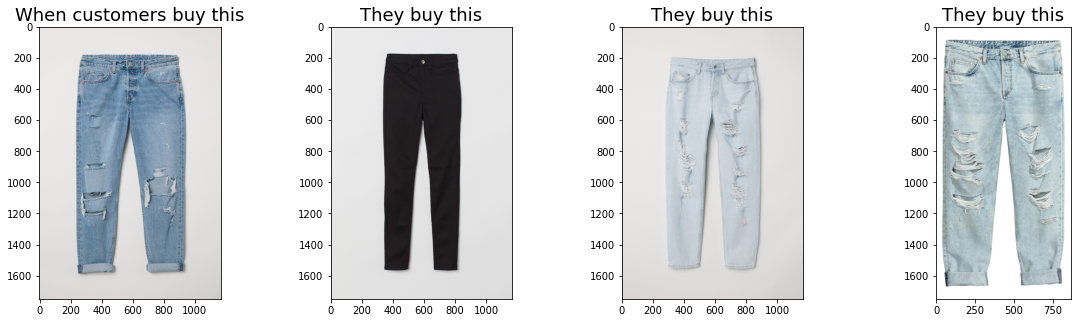

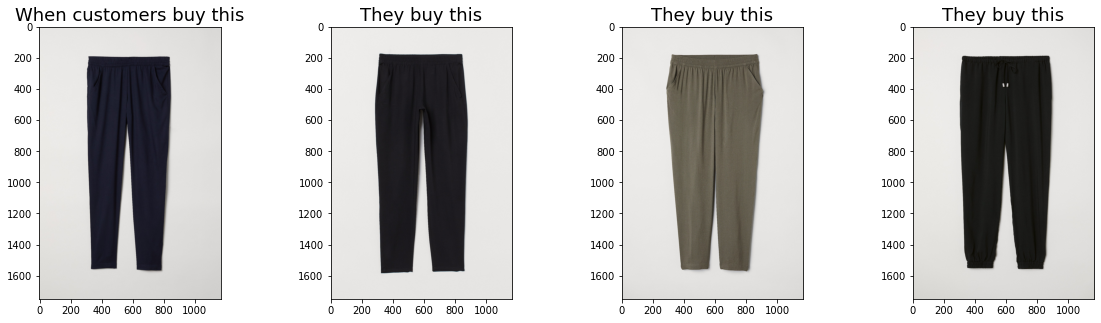

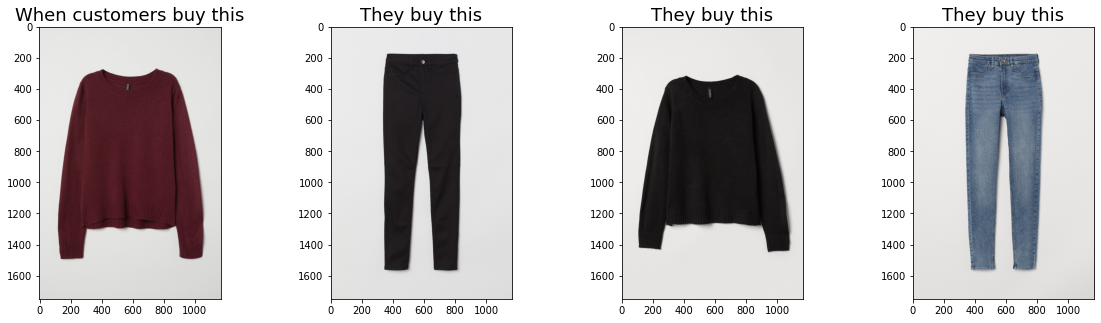

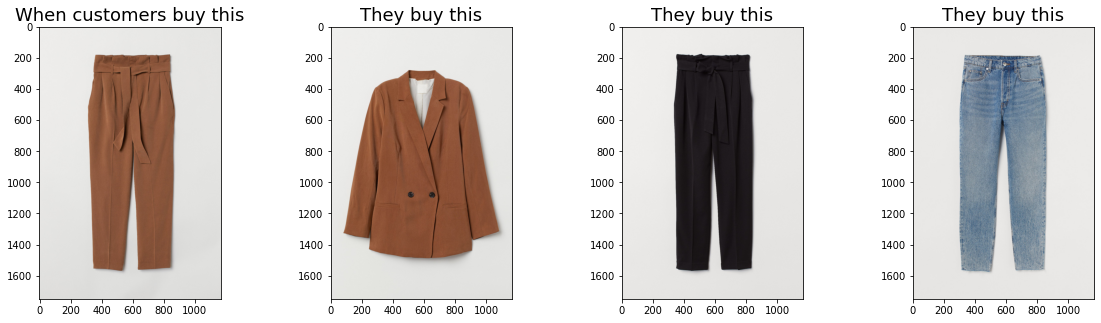

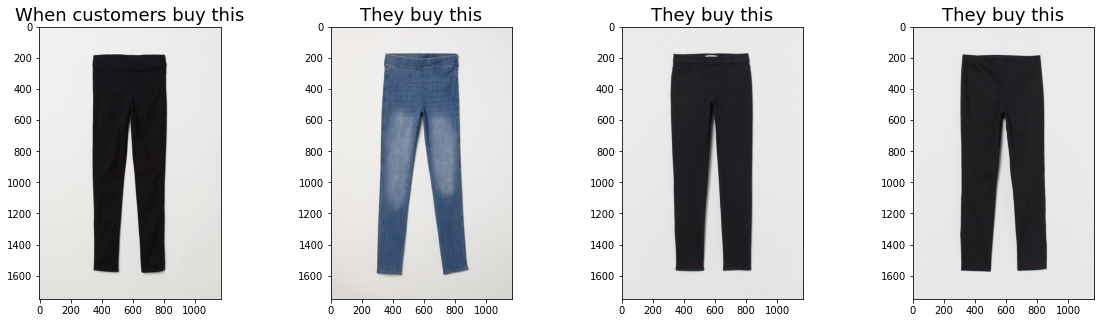

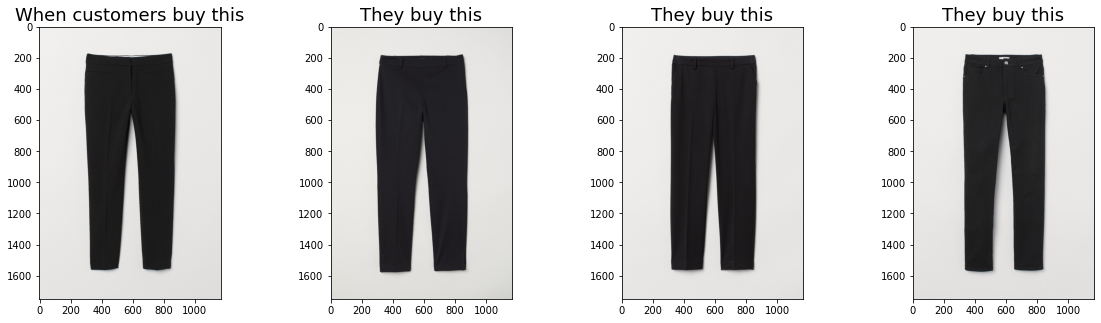

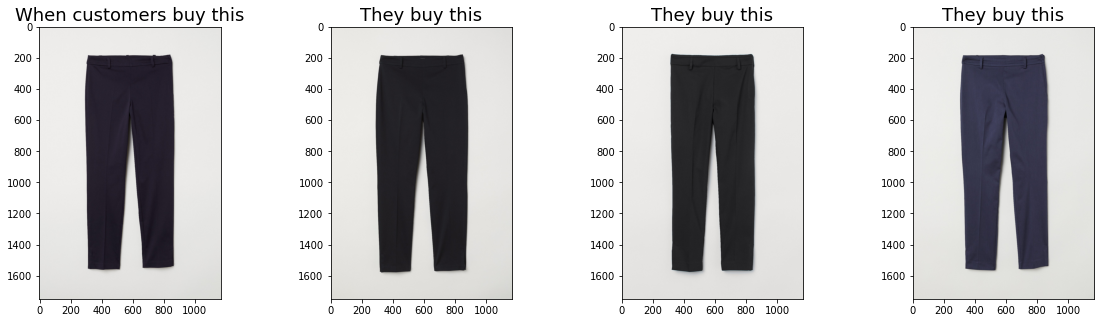

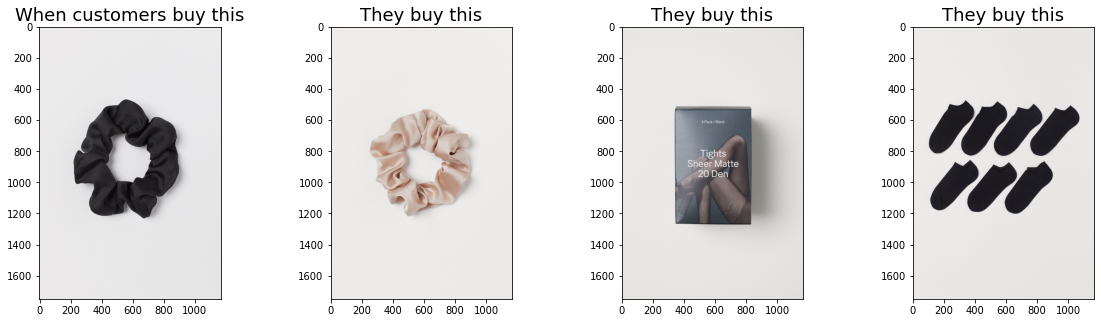

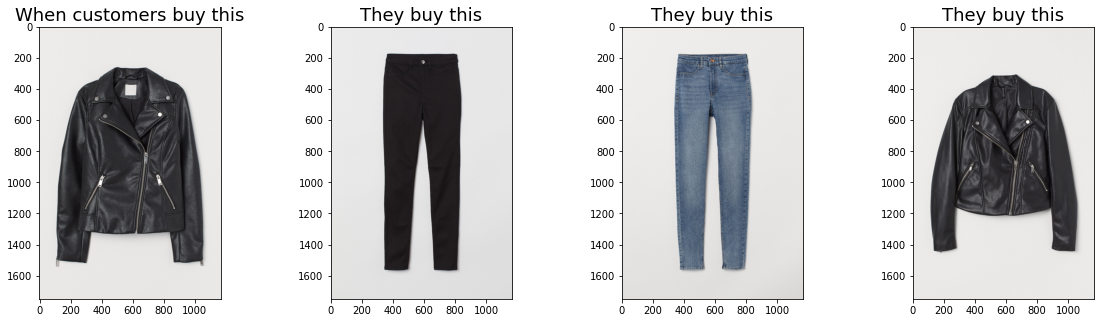

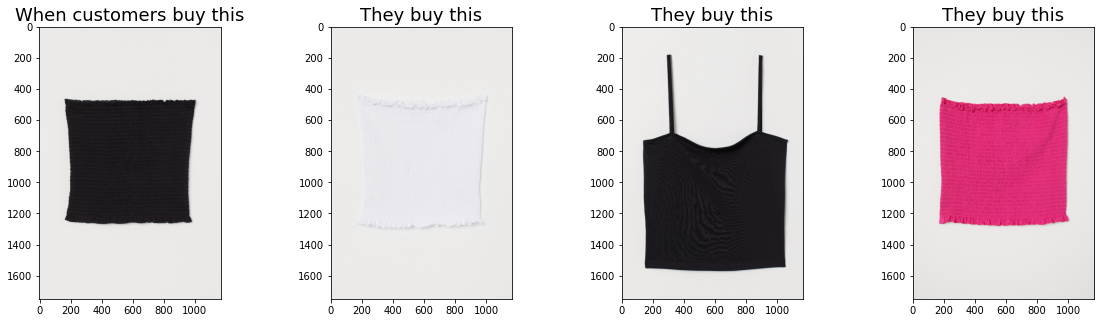

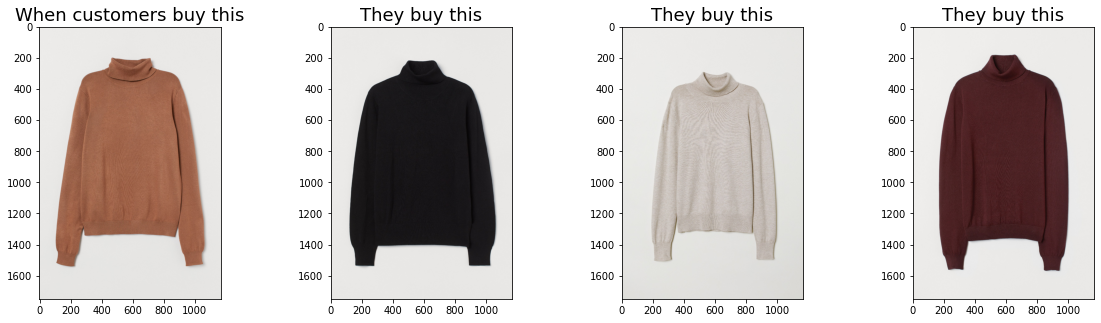

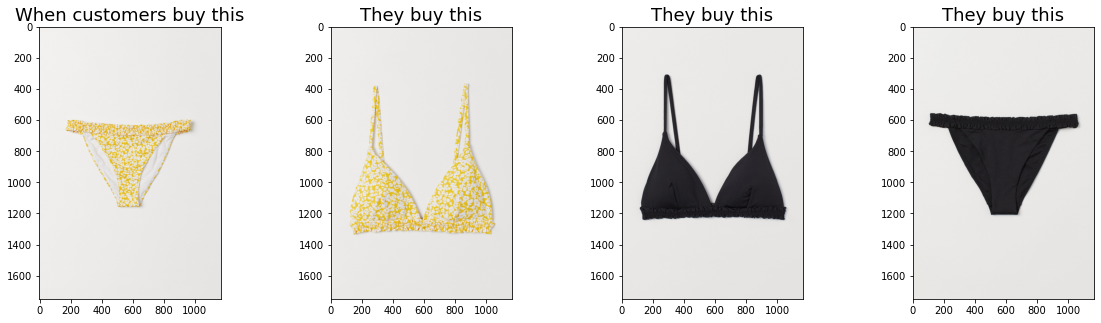

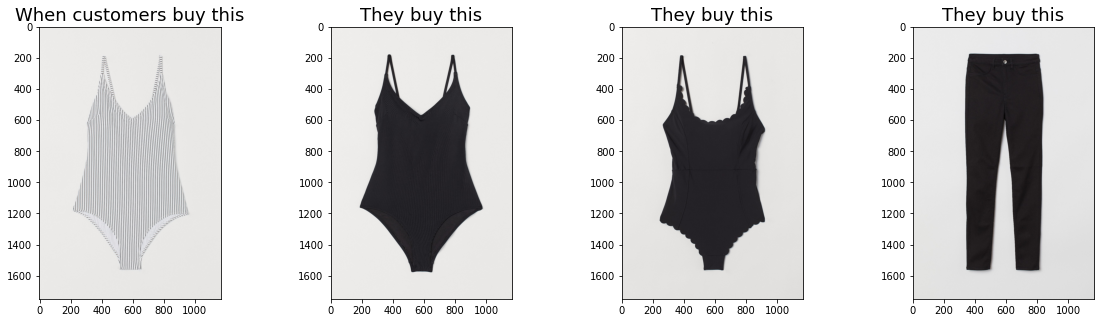

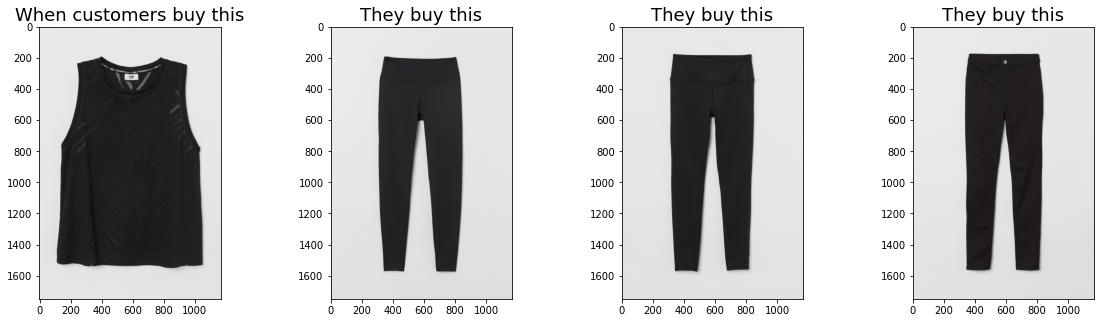

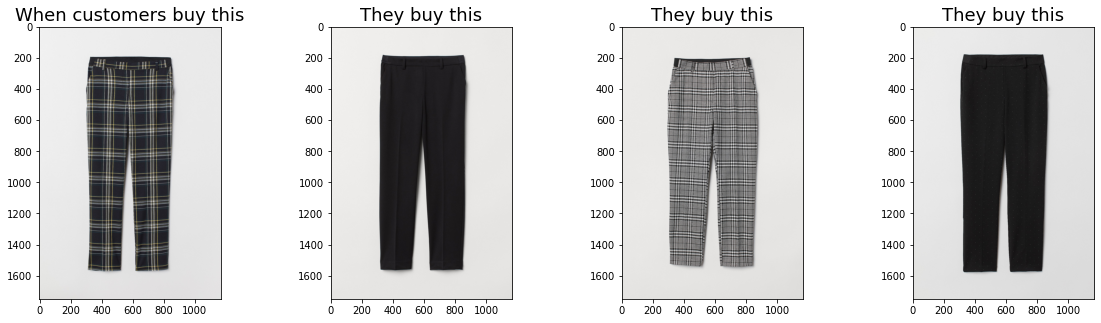

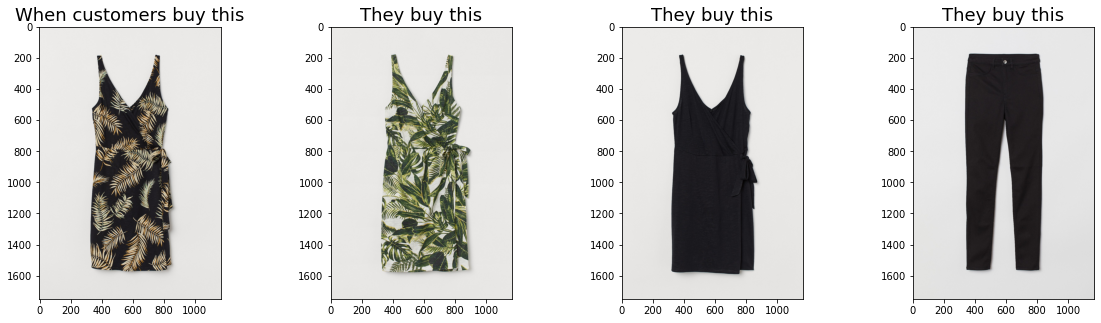

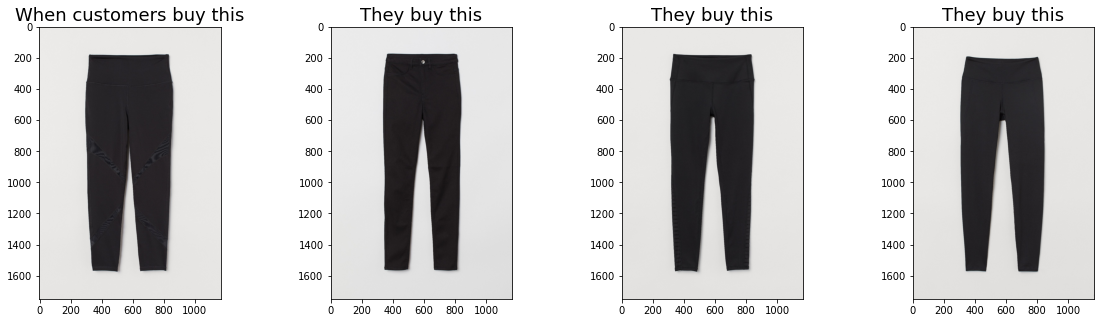

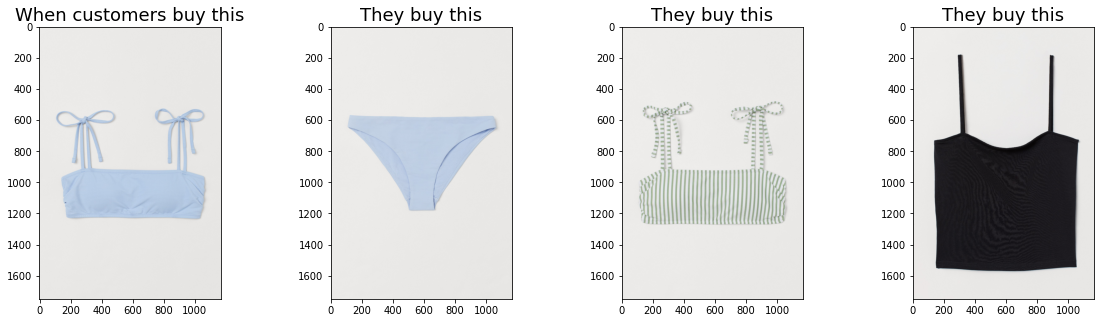

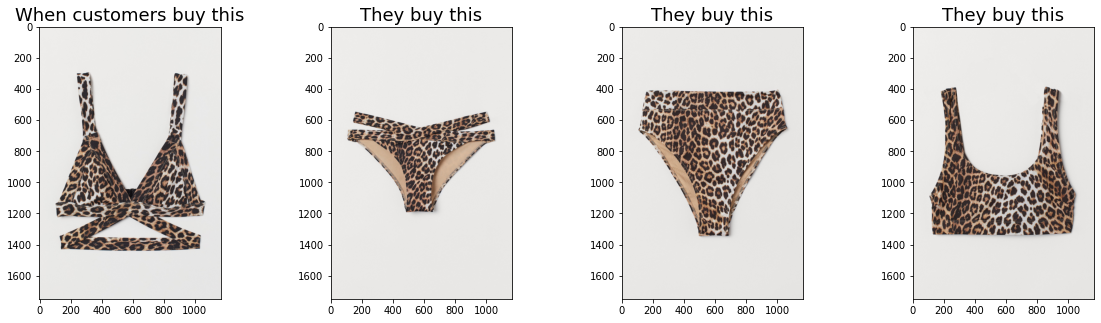

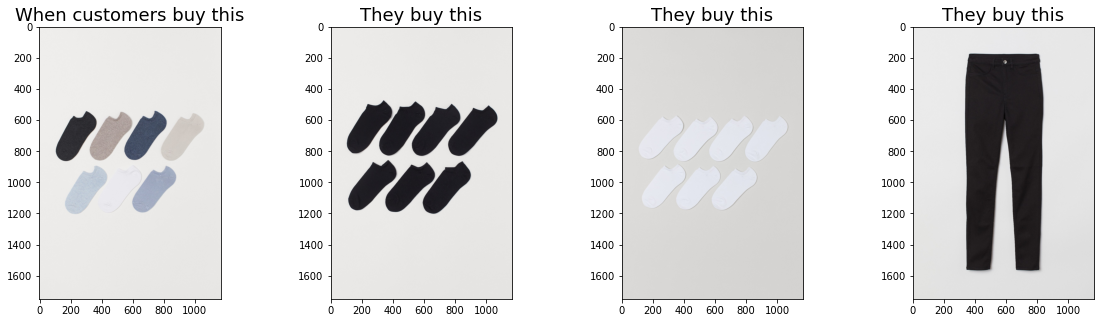

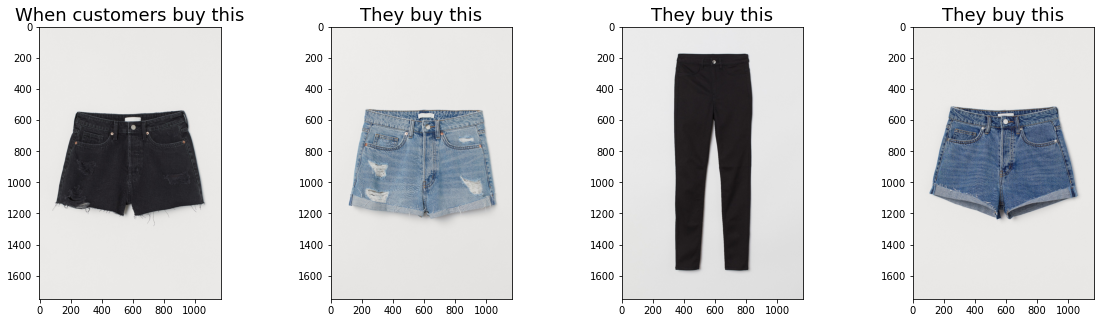

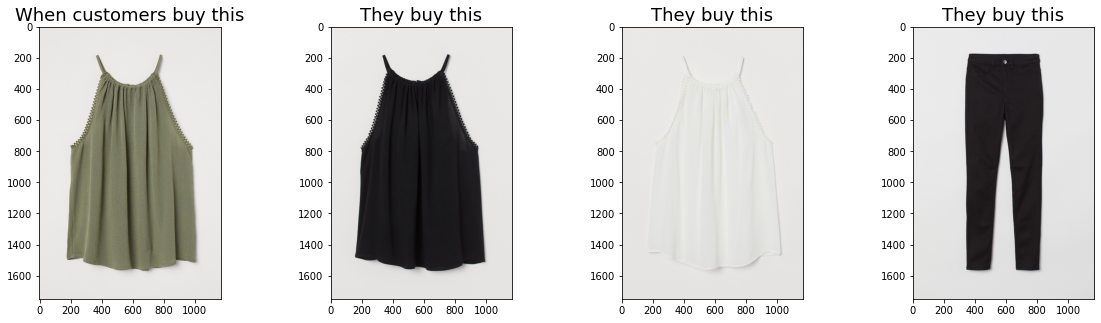

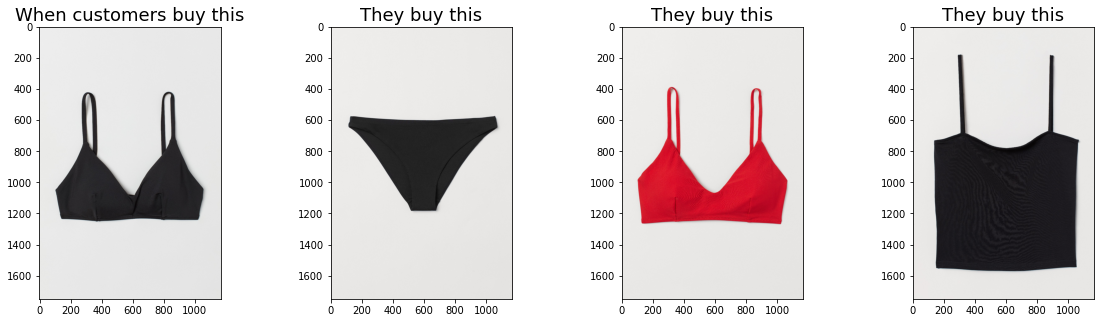

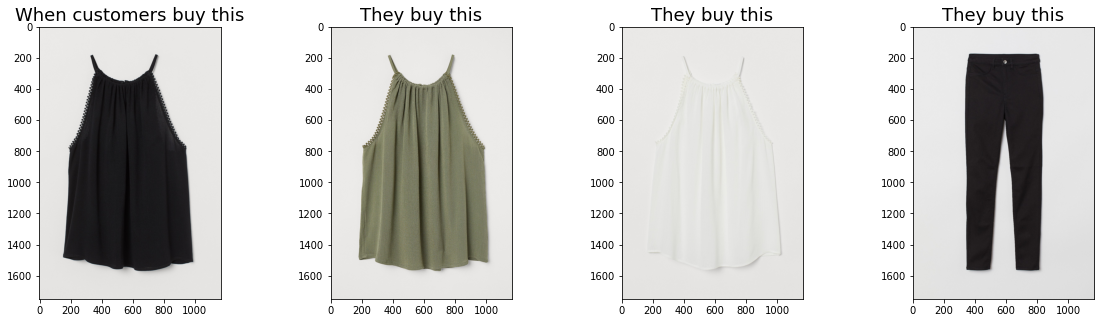

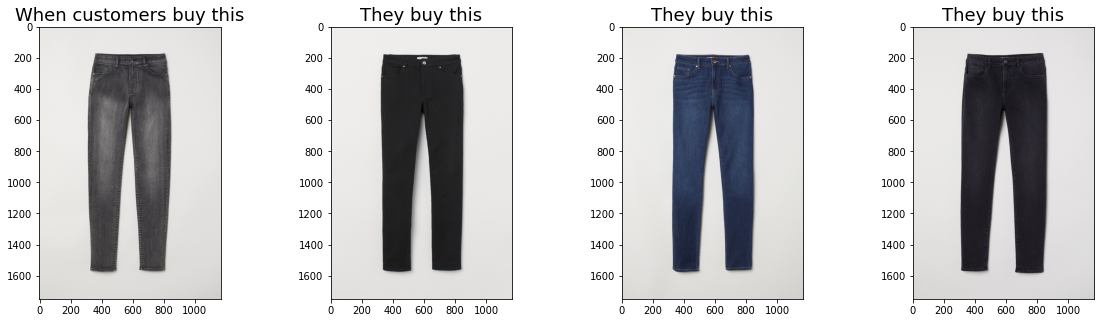

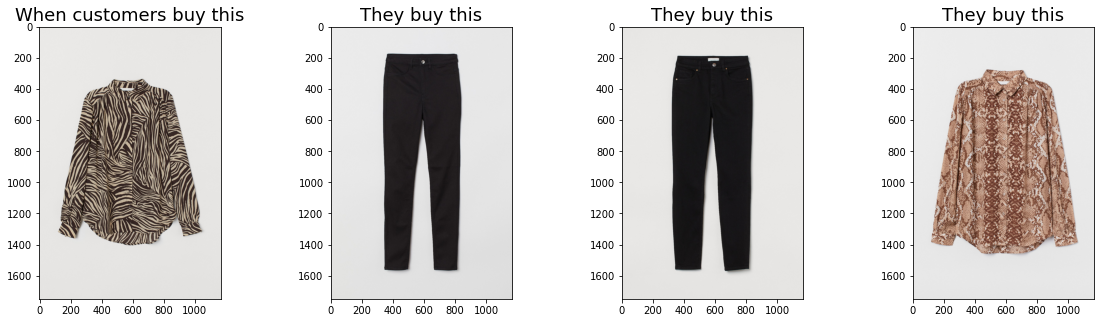

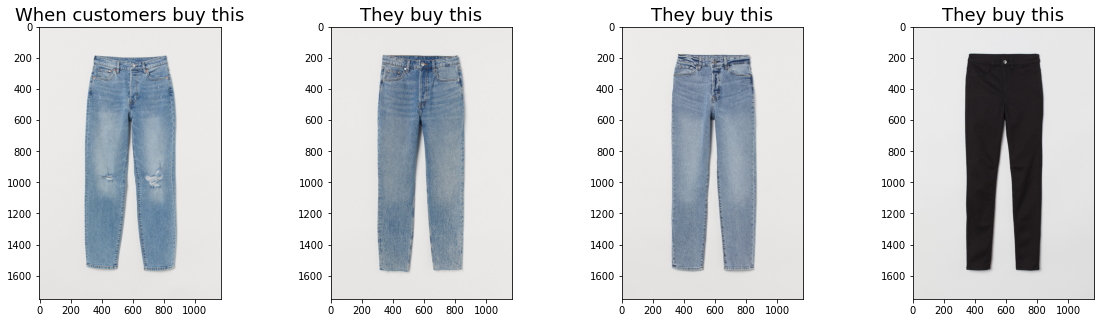

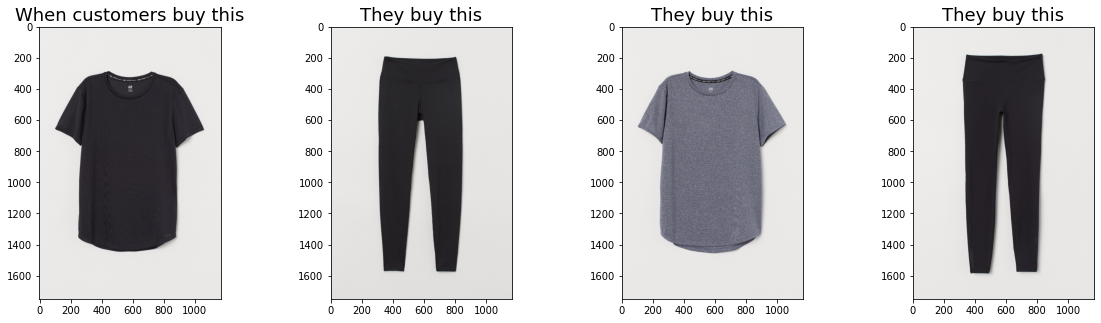

In [ ]:
items = cudf.read_csv('../input/h-and-m-personalized-fashion-recommendations/articles.csv')
BASE = '../input/h-and-m-personalized-fashion-recommendations/images/'

for i,(k,v) in enumerate( item_pairs.items() ):
    name1 = BASE+'0'+str(k)[:2]+'/0'+str(k)+'.jpg'
    name2 = BASE+'0'+str(v[0])[:2]+'/0'+str(v[0])+'.jpg'
    name3 = BASE+'0'+str(v[1])[:2]+'/0'+str(v[1])+'.jpg'
    name4 = BASE+'0'+str(v[2])[:2]+'/0'+str(v[2])+'.jpg'
    if exists(name1) & exists(name2) & exists(name3) & exists(name4):
        plt.figure(figsize=(20,5))
        img1 = cv2.imread(name1)[:,:,::-1]
        img2 = cv2.imread(name2)[:,:,::-1]
        img3 = cv2.imread(name3)[:,:,::-1]
        img4 = cv2.imread(name4)[:,:,::-1]
        plt.subplot(1,4,1)
        plt.title('When customers buy this',size=18)
        plt.imshow(img1)
        plt.subplot(1,4,2)
        plt.title('They buy this',size=18)
        plt.imshow(img2)
        plt.subplot(1,4,3)
        plt.title('They buy this',size=18)
        plt.imshow(img3)
        plt.subplot(1,4,4)
        plt.title('They buy this',size=18)
        plt.imshow(img4)
        plt.show()
    if i==63: break

# Find customer's previously purchased products

In [ ]:
tmp = train.groupby(['customer_id','article_id'])['t_dat'].agg('count').reset_index()
tmp.columns = ['customer_id','article_id','ct']
train = train.merge(tmp,on=['customer_id','article_id'],how='left')
train = train.sort_values(['ct','t_dat'],ascending=False)
train = train.drop_duplicates(['customer_id','article_id'])
train = train.sort_values(['ct','t_dat'],ascending=False)

# Group by 'customer_id' and find the most recent transaction date ('t_dat') for each customer
recent_transactions = train.groupby('customer_id').t_dat.max().reset_index()
recent_transactions.columns = ['customer_id', 'max_dat']

# Merge the recent transaction dates back into the original 'train' DataFrame
train = train.merge(recent_transactions, on='customer_id', how='left')

# Calculate the difference in days between the most recent transaction date and each transaction date
train['diff_dat'] = (train['max_dat'] - train['t_dat']).dt.days

# Filter the DataFrame to include only transactions within the last 6 days
train = train.loc[train['diff_dat'] <= 6]

# Print the shape of the filtered DataFrame
print('Train shape:', train.shape)

train.head()

t_dat          customer_id  article_id    max_dat  diff_dat   ct
1122144 2019-07-16  2729025827381139556   719348003 2019-07-16         0  100
60704   2018-10-04  4485518665254175540   557247001 2018-10-04         0   86
2139297 2020-03-06  -906958334866810496   852521001 2020-03-06         0   81
3373760 2020-07-06  3601599666106972342   685813001 2020-07-06         0   80
850433  2019-05-14 -4601407992705575197   695545001 2019-05-14         0   80

# Recommend Products Frequently Purchased Together

re-iterating `item_pairs` over the whole dataset, we can recommend products frequently purchased together


In [ ]:
# Initialize an empty dictionary to store item pairs
pairs = {}

# Iterate over a slice of the most frequent article_ids
for index, article_id in enumerate(article_counts.index.values):
    # Find all unique customers who purchased the current article_id
    customers = df.loc[df.article_id == article_id, 'customer_id'].unique()
    
    # Find other articles purchased by these customers, excluding the current article_id
    other_articles_counts = df.loc[
        (df.customer_id.isin(customers)) & (df.article_id != article_id), 
        'article_id'
    ].value_counts().index
    
    # Store the most frequently purchased articles with the current article_id
    pairs[article_id] = other_articles_counts[0].tolist()

# Map the article_id column to the pairs dictionary to get paired items
train['article_id2'] = train.article_id.map(pairs)

# Create a new DataFrame with customer_id and article_id2
train2 = train[['customer_id', 'article_id2']].copy()

# Filter out rows where article_id2 is null
train2 = train2.loc[train2.article_id2.notnull()]

# Remove duplicate rows based on customer_id and article_id2 so we  don't recommend duplicate items
train2 = train2.drop_duplicates(['customer_id', 'article_id2'])

# Rename article_id2 to article_id
train2 = train2.rename({'article_id2': 'article_id'}, axis=1)

# Concatenate the original train DataFrame with the new recommendations
train = train[['customer_id', 'article_id']]
train = pd.concat([train, train2], axis=0, ignore_index=True)

# Convert article_id to int32 type
train.article_id = train.article_id.astype('int32')

# Remove duplicate rows based on customer_id and article_id
train = train.drop_duplicates(['customer_id', 'article_id'])

# Convert article_id to string and prefix with ' 0'
train.article_id = ' 0' + train.article_id.astype('str')

# Group by customer_id and concatenate article_id values into a single string
preds = cudf.DataFrame(train.groupby('customer_id').article_id.sum().reset_index())

# Rename columns to customer_id and prediction
preds.columns = ['customer_id', 'prediction']

# Display the first few rows of the resulting recommendations
preds.head()

# Fill in Recommendations with Popular Products
If our previous recommendations did not fill up a customer's 12 recommendations we will fill the rest with popular products.

In [ ]:
# Filter the DataFrame to include only transactions from the last week
start_date = cudf.to_datetime('2020-09-16')
train = train.loc[train.t_dat >= start_date]

# Calculate the top 12 most popular items based on transaction counts
top12_items = train.article_id.value_counts().to_pandas().index.astype('str')[:12]

# Join the top 12 items into a single string, prefixed and separated by ' 0'
top12 = ' 0' + ' 0'.join(top12_items)

# Print the top 12 popular items from the last week
print("Last week's top 12 popular items:")
print(top12)

Last week's top 12 popular items:
 0924243001 0924243002 0918522001 0923758001 0866731001 0909370001 0751471001 0915529003 0915529005 0448509014 0762846027 0714790020
